# Tutorial 3
This tutorial uses the WaveBot geometry in degree of freedom in regular waves. The goal is to maximize aborbed power by varying the radius of the hull at the keel (`r2`), while maintaining a constant volume. This is acheived by setting `h2` in conjunction with `r2`.
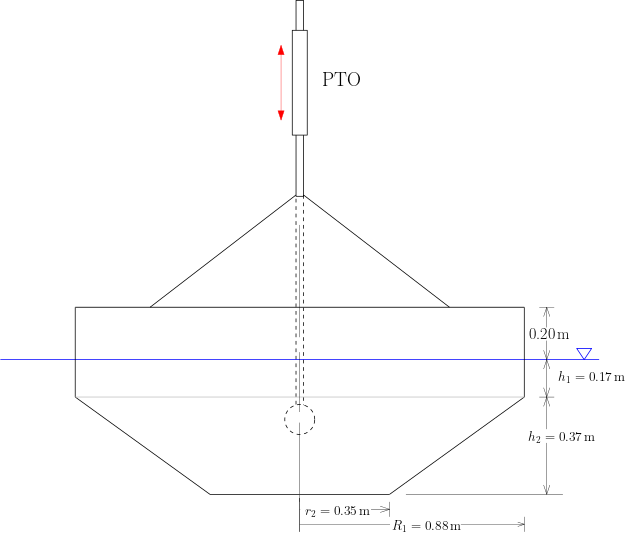

In [1]:
import logging
import os

import autograd.numpy as np
from autograd.builtins import isinstance, tuple, list, dict
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute

import wecopttool as wot
from wecopttool.geom import WaveBot

# os.chdir(os.path.split(os.path.realpath(__file__))[0])

logging.basicConfig(level=logging.INFO)

First, we can find a set of values for `h2` based on `r1`. We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

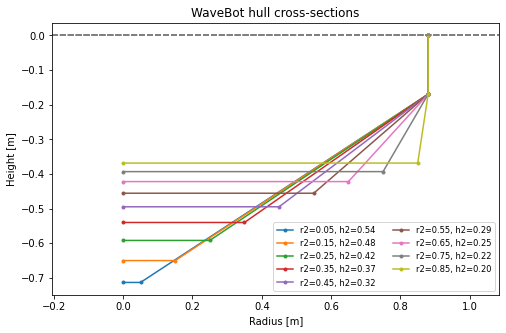

In [27]:
r2_vals = np.arange(0.05, 0.95, 0.1)

r1 = 0.88
r2_0 = 0.35
h2_0 = 0.37
V0 = 1/3*np.pi*h2_0*(r1**2+r2_0**2+(r1*r2_0))


def h2_from_r2(r2, V=V0, r1=r1):
    h2 = V/(1/3*np.pi*(r1**2+r2**2+(r1*r2)))
    return h2


mapres = map(h2_from_r2, r2_vals)
h2_vals = list(mapres)

fig1, ax1 = plt.subplots(figsize=(8,5))
_ = [WaveBot(r2=r2, h2=h2).plot_cross_section(ax=ax1, label=f"r2={r2:.2f}, h2={h2:.2f}") 
     for r2, h2 in zip(r2_vals.tolist(), h2_vals)]
ax1.legend(loc='best', fontsize='small',ncol=2)
_ = ax1.set_title('WaveBot hull cross-sections')

Next we will define an objective function for our design optimization problem. We use the same workflow illustrated in Tutorial 1 to set up a WaveBot device, but wrap this in a function definition which can set `r2` and (indirectly) `h2`.

In [3]:
def design_obj_fun(x):

    r2 = x[0]

    h2 = h2_from_r2(r2)

    # generate a surface mesh for the WaveBot with which to perform BEM calcs
    wb = WaveBot(r2=r2, h2=h2)
    mesh = wb.mesh(mesh_size_factor=0.5)

    # capytaine floating body (mesh + DOFs)
    fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
    fb.add_translation_dof(name="HEAVE")

    # mass & hydrostatic stiffness
    rho = 1000.0  # fresh water

    hs_data = wot.hydrostatics.hydrostatics(fb, rho=rho)
    mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
    mass = np.atleast_2d(mass_33)
    stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
    stiffness = np.atleast_2d(stiffness_33)

    # frequencies
    f0 = 0.05
    nfreq = 50

    # PTOs (additional force + constraint + objective function)
    kinematics = np.eye(fb.nb_dofs)
    pto = wot.pto.PseudoSpectralPTO(nfreq, kinematics)

    # constraints at 4x points
    nsubsteps = 4
    f_max = 2000.0

    def const_f_pto(wec, x_wec, x_opt):
        f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq',
                 'fun': const_f_pto,
                 }
    constraints = [ineq_cons]

    # additional friction
    dissipation = 160.3

    # create WECs
    f_added = pto.force_on_wec

    my_wec = wot.WEC(fb, mass, stiffness, f0, nfreq, rho=rho, f_add=f_added,
                     # constraints=constraints,
                     dissipation=dissipation,
                     )

    # create save directory
    results_super_dir = 'results_tutorial_3_optimization'
    if not os.path.exists(results_super_dir):
      os.makedirs(results_super_dir)

    results_dir = os.path.join(results_super_dir, f"{x[0]:.2f}")
    if not os.path.exists(results_dir):
      os.makedirs(results_dir)

    # read BEM if available, else run & save
    fname = os.path.join(results_dir, 'bem.nc')
    if os.path.exists(fname):
        my_wec.read_bem(fname)
    else:
        my_wec.run_bem()
        my_wec.write_bem(fname)
        mesh.write(os.path.join(results_dir, f"{x[0]:.2f}.stl"))

    wfreq = 0.6
    amplitude = 0.0625
    phase = -40
    waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

    options = {'maxiter': 1000, 'ftol': 1e-8}
    obj_fun = pto.average_power
    nstate_opt = pto.nstate

    wec_tdom, wec_fdom, x_wec, x_opt, obj, _ = my_wec.solve(waves,
                                                            obj_fun,
                                                            nstate_opt,
                                                            optim_options=options,
                                                            scale_x_opt=1e3)

    avg_power = obj

    return avg_power

Finally, we may call this objective function with an optimization algorithm. Here, a simple *brute force* optimization approach is used here for illustrative purposes, but any variety of options could be applied. The optimization algorithm will call our objective function, which in turn will create a new WaveBot hull, run the necessary BEM calculations for the hull, and find the trajectory that provides the most absorbed power for that hull. This process will be conducted for the range of `r2` values that we specify.

In [4]:
res = brute(func=design_obj_fun,
            # range over which to search
            ranges=(slice(r2_vals[0], r2_vals[-1], np.diff(r2_vals)[0]),),
            full_output=True,  # return eval grid and obj fun values
            finish=None,  # no "polishing" at end (e.g., via gradient method)
            )

INFO:capytaine.bodies.bodies:Stored 1304 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solve

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.367, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.996, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.996, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve Diff

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, depth=inf, radiating_dof=HEAVE).
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calcu

Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.58087977618823
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, ra

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.739, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.367, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve Diffra

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.765, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, depth=inf, radiating_dof=HEAVE).
INFO:wecopttool.core:Impedance matri

Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.53983663530104
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, ra

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.367, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.996, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve Radia

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, depth=inf, radiating_dof=HEAVE).
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calcu

Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.514944909994359
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, ra

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=9.739, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.367, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve Diffra

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=14.765, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, depth=inf, radiating_dof=HEAVE).
INFO:wecopttool.core:Impedance matri

Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.502808555218675
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, ra

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.367, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.996, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve Radia

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, depth=inf, radiating_dof=HEAVE).
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calcu

Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.48034234024927
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, ra

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.367, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.996, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.996, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve Diff

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, depth=inf, radiating_dof=HEAVE).
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_

Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.451180852633431
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, ra

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.367, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.996, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve Radia

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, depth=inf, radiating_dof=HEAVE).
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calcu

Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.41614916680177
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Running Capytaine (BEM): 50 frequencies x 1 wave directions.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, ra

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=9.739, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.053, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.053, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.367, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.367, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.681, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=10.681, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=10.996, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve Radia

INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=14.765, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.080, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.080, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.394, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.394, depth=inf, radiating_dof=HEAVE).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=15.708, depth=inf, wave_direction=0.000).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=15.708, depth=inf, radiating_dof=HEAVE).
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calcu

Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.407842914066848
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17


From a quick plot of the results, we see that the power absorption (where negative power is power absorbed by the device) improves for smaller values of `r2`.

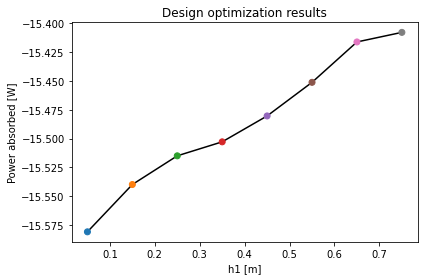

In [29]:
fig2, ax2 = plt.subplots()

ax2.plot(res[2], res[3],
         'k',
         zorder=0)
ax2.scatter(res[2], res[3],
            c=plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(res[2])],
            zorder=1)

ax2.set_xlabel('h1 [m]')
ax2.set_ylabel('Power absorbed [W]')
ax2.set_title('Design optimization results')
fig2.tight_layout()

plt.show()